In [ ]:
# default_exp hamilton

In [ ]:
# export
# server
import torch
import torch.nn as nn
import torch.nn.functional as F

# hamilton

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#slow
%matplotlib inline
import matplotlib.pyplot as plt

Staggered midpoint

\begin{equation}
x_n = x_{n-1} + k y_{n-\frac{1}{2}}, y_{n+\frac{1}{2}} = y_{n-\frac{1}{2}} - k x_n, n = 1,\ldots,N-1,
\end{equation}
starting with $y_{\frac{1}{2}} = y_{0} - \frac{k}{2} x_0$ and ending with 
$x_N = x_{N-1} + k y_{N-\frac{1}{2}}, y_{N} = y_{N-\frac{1}{2}} - \frac{k}{2} x_n$.
This is called the **Stormer-Verlet** method.

Ref: Uri M. Ascher. Numerical methods for Evolutionary Differential Equations.

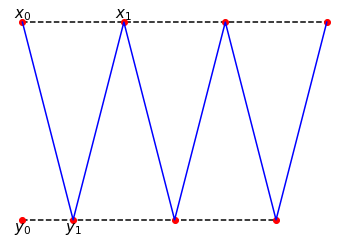

In [ ]:
#slow
x0 = [0, 0, 0.5, 1, 1.5, 2, 2.5, 3]
y0 = [0, 1, 0, 1, 0, 1, 0, 1]
x1 = [0, 0.5, 1, 1.5, 2, 2.5, 3]
y1 = [1, 0, 1, 0, 1, 0, 1]
plt.axis('off')
plt.plot(x0, y0, 'ro', x1, y1, 'b-')
plt.hlines(0, 0, 2.5, linestyles='dashed')
plt.hlines(1, 0, 3, linestyles='dashed')
plt.text(0, 1, '$x_0$', horizontalalignment='center', verticalalignment='bottom', fontsize=15)
plt.text(0, 0, '$y_0$', horizontalalignment='center', verticalalignment='top', fontsize=15)
plt.text(1, 1, '$x_1$', horizontalalignment='center', verticalalignment='bottom', fontsize=15)
plt.text(0.5, 0, '$y_1$', horizontalalignment='center', verticalalignment='top', fontsize=15)
plt.show()

In [ ]:
#export
class HamLinear(nn.Module):
    """
    Hamilonian Linear Module.
    Args:
    -- row, col: 
    -- alpha:
    -- std:
    -- act:
    -- is_alpha_trainable:
    """
    def __init__(self, row:int, col:int, alpha:float, std:float=None, act:nn.Module=nn.ReLU, is_alpha_trainable:bool=False):
        super(HamLinear, self).__init__()
        if std is None:
            self.std = torch.sqrt(2*torch.tensor(row+col, dtype=torch.float))
        else:
            self.std = torch.tensor(std, dtype=torch.float)
            
        self.W = nn.Parameter(torch.randn(row, col) / self.std)
        
        if is_alpha_trainable:
            self.alpha = nn.Parameter(torch.tensor(alpha))
        else:
            self.alpha = torch.tensor(alpha)
        
        self.act = act()
    
    def forward(self, x, y:torch.tensor=None):
        if y is None:
            y = self.alpha / 2 * self.act(x).matmul(-self.W.T)
        else:
            x = x + self.alpha * self.act(y).matmul(self.W)
            y = y + self.alpha * self.act(x).matmul(-self.W.T)
        return x, y

### Evaluate the relationship between convolution and transposed convolution in Pytorch

In [ ]:
kernels = torch.arange(9).reshape(1,1,3,3)
inputs = torch.arange(16).reshape(1,1,4,4)
outputs = F.conv2d(inputs, kernels, padding=0)
outputs

tensor([[[[258, 294],
          [402, 438]]]])

In [ ]:
inputs2 = F.conv_transpose2d(outputs, kernels, padding=0)

In [ ]:
C = torch.zeros(4, 16)
C[0, 0:3] = kernels[0,0,0,:]
C[0, 4:7] = kernels[0,0,1,:]
C[0, 8:11] = kernels[0,0,2,:]

C[1, 1:4] = kernels[0,0,0,:]
C[1, 5:8] = kernels[0,0,1,:]
C[1, 9:12] = kernels[0,0,2,:]

C[2, 4:7] = kernels[0,0,0,:]
C[2, 8:11] = kernels[0,0,1,:]
C[2, 12:15] = kernels[0,0,2,:]

C[3, 5:8] = kernels[0,0,0,:]
C[3, 9:12] = kernels[0,0,1,:]
C[3, 13:16] = kernels[0,0,2,:]

In [ ]:
C2 = C.T.matmul(C)
C2.shape

torch.Size([16, 16])

In [ ]:
inputs2 = inputs2.reshape(4,4).type(torch.float)
inputs2

tensor([[   0.,  258.,  810.,  588.],
        [ 774., 2316., 3708., 2346.],
        [2754., 6492., 7884., 4542.],
        [2412., 5442., 6282., 3504.]])

In [ ]:
C2.matmul(torch.arange(16).type(torch.float))

tensor([   0.,  258.,  810.,  588.,  774., 2316., 3708., 2346., 2754., 6492.,
        7884., 4542., 2412., 5442., 6282., 3504.])

In [ ]:
from putixin.data import *

In [ ]:
bs = 4
fashion_mnist_train_loader, fashion_mnist_test_loader = data(cfg_fashion_mnist, bs=bs)

In [ ]:
fashion_mnist_train_loader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /home/fengwf/.putixin/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [ ]:
I = iter(fashion_mnist_train_loader)

In [ ]:
next(I)[1].shape

torch.Size([4])

In [ ]:
batch_images = next(I)[0]
batch_images.shape

torch.Size([4, 1, 28, 28])

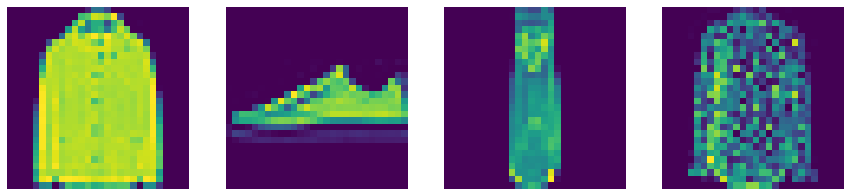

In [ ]:
plt.figure(figsize=(15,15))
for i in range(bs):
    plt.subplot(1, bs, i+1)
    plt.axis('off')
    plt.imshow(batch_images[i,0,:,:].detach().numpy())

In [ ]:
sobel_kernel = torch.tensor([[-1,-2,-1],
                             [0, 0, 0],
                             [1, 2, 1]], dtype=torch.float)

In [ ]:
sobel_kernel = sobel_kernel.reshape(1,1,3,3)

In [ ]:
outputs = F.conv2d(batch_images, sobel_kernel, padding=0)

In [ ]:
outputs.shape

torch.Size([4, 1, 26, 26])

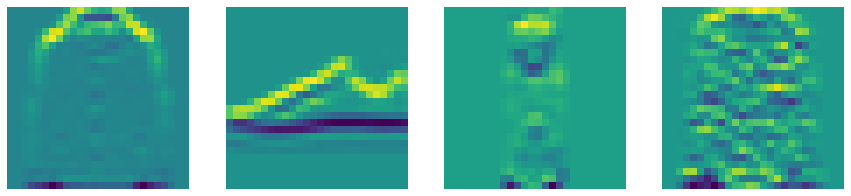

In [ ]:
plt.figure(figsize=(15,15))
for i in range(bs):
    plt.subplot(1, bs, i+1)
    plt.axis('off')
    plt.imshow(outputs[i,0,:,:].detach().numpy())

In [ ]:
inputs = F.conv_transpose2d(outputs, sobel_kernel, padding=0)

In [ ]:
inputs.shape

torch.Size([4, 1, 28, 28])

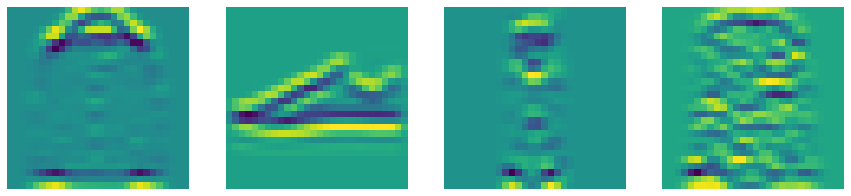

In [ ]:
plt.figure(figsize=(15,15))
for i in range(bs):
    plt.subplot(1, bs, i+1)
    plt.axis('off')
    plt.imshow(inputs[i,0,:,:].detach().numpy())

In [ ]:
row, col = 28*28, 28*28
alpha = 1.
act = nn.ReLU # nn.Sigmoid # nn.Tanh # nn.ReLU  # nn.Identity
ham_init = HamLinear(row, col, alpha, act=act)


In [ ]:
x0 = batch_images.view(bs, -1)
x = x0
x, y = ham_init(x)
out_data = y.view(bs,1,28,28)
out_data.shape

torch.Size([4, 1, 28, 28])

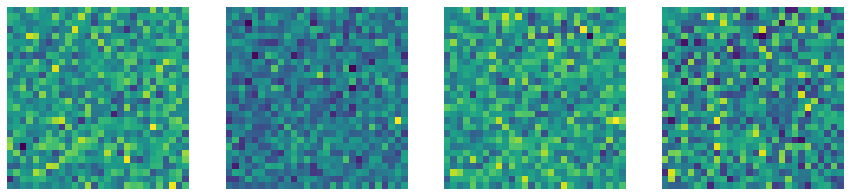

In [ ]:
plt.figure(figsize=(15,15))
for i in range(bs):
    plt.subplot(1, bs, i+1)
    plt.axis('off')
    plt.imshow(out_data[i,0,:,:].detach().numpy())

In [ ]:
ham_linear = HamLinear(row, col, alpha, act=act)

In [ ]:
x1, y1 = ham_linear(x, y)

In [ ]:
out_data = x1.view(bs,1,28,28)
out_data.shape

torch.Size([4, 1, 28, 28])

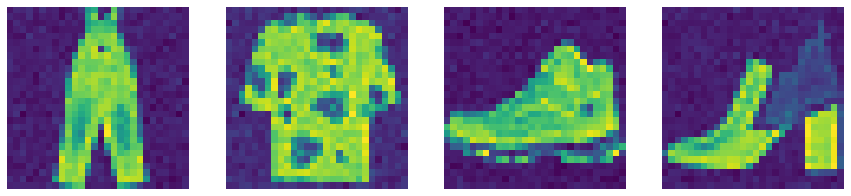

In [ ]:
plt.figure(figsize=(15,15))
for i in range(bs):
    plt.subplot(1, bs, i+1)
    plt.axis('off')
    plt.imshow(out_data[i,0,:,:].detach().numpy())